# Machine Learning Fundamentals - Lecture 08

This is the Jupyter notebook for Lecture 08 of the Machine Learning Fundamentals course.

In [247]:
# Import the required libraries using the commonly use short names (pd, sns, ...)
import pandas as pd
import numpy as np

# The Path object from pathlib allows us to easily build paths in an
# OS-independent fashion
from pathlib import Path

# The literal_eval() function allows us to evaluate Python code itself, which
# will be useful down the road
from ast import literal_eval

# Useful for hiding convergence warnings when we set max_iters=1
import warnings

# Load the required scikit-learn classes and functions
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.exceptions import ConvergenceWarning

# Import Keras stuff
import keras
from keras import layers, regularizers
from keras import initializers

# Load matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nicer style for Seaborn plots
sns.set_style("darkgrid")

## Load dataset and perform initial assessment

We'll start by loading the dataset, and take a look at what information is
contained there.

In [248]:
# Load the dataset (note the use of the Path object)
df = pd.read_csv(Path("..", "datasets", "high_diamond_ranked_10min.csv"))

# See standard descriptive statistics about each column (expect gameId, see
# below)
# - The T property allows us to see the dataframe transposed, which is more
# useful when we have a large number of features, which is the case here
df.drop(columns=["gameId"]).describe().T

,count,mean,std,min,25%,50%,75%,max
blueWins,9879.0,0.499038,0.500024,0.0,0.00,0.0,1.00,1.0
blueWardsPlaced,9879.0,22.288288,18.019177,5.0,14.00,16.0,20.00,250.0
blueWardsDestroyed,9879.0,2.824881,2.174998,0.0,1.00,3.0,4.00,27.0
blueFirstBlood,9879.0,0.504808,0.500002,0.0,0.00,1.0,1.00,1.0
blueKills,9879.0,6.183925,3.011028,0.0,4.00,6.0,8.00,22.0
blueDeaths,9879.0,6.137666,2.933818,0.0,4.00,6.0,8.00,22.0
blueAssists,9879.0,6.645106,4.064520,0.0,4.00,6.0,9.00,29.0
blueEliteMonsters,9879.0,0.549954,0.625527,0.0,0.00,0.0,1.00,2.0
blueDragons,9879.0,0.361980,0.480597,0.0,0.00,0.0,1.00,1.0
blueHeralds,9879.0,0.187974,0.390712,0.0,0.00,0.0,0.00,1.0


Now that we took a look at the columns, let's organize the data into features
`X` and labels `y`, making it ready for us to start the requested tasks.

We'll drop the `"gameID"` column, since it won't be useful for us (it serves
only to get more info from the Riot API). We'll also drop the `"blueWins"`
column from the features, since this is the label we aim to predict (i.e., it'll
be our `y`).

In [249]:
# Get our features into the X matrix, dropping the gameId column (we won't need
# it) and the blueWins column (because it contains the target labels we aim to
# predict)
X = df.drop(columns=["gameId", "blueWins"]).to_numpy()

# Get the labels into the y vector
y = df["blueWins"].to_numpy()

In [250]:
# Quick look at X's shape: 9879 examples, 38 features
X.shape

(9879, 38)

Before we start searching for the best MLP parameters to perform this
classification, let's split the data into train and test sets:

In [251]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## Search for best parameters

For this homework, we'll try different types of activation function, different L2 regularization levels ($\alpha$), and several topologies (number of hidden layers, with different sizes, etc). 

In [252]:
# Create a pipeline incorporating standard scaling and classification with a
# MLP classifier
pipe = Pipeline(
    [
        ("scale", StandardScaler()),
        ("mlp", MLPClassifier(random_state=321, max_iter=3000)),
    ]
)

# Specify the parameters to search
# Since were using a pipeline, we need to prefix each parameter with the tag
# identifying our classifier within the pipeline
param_grid = {
    "mlp__alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10],
    "mlp__activation": ["logistic", "tanh", "relu"],
    "mlp__hidden_layer_sizes": [
        [4],
        [8],
        [100],
        [4, 8],
        [6, 12],
        [4, 8, 4],
        [6, 12, 6],
    ],
}

In [253]:
# Perform grid search using 5-fold cross-validation, score using the F1 metric
# (macro), use all CPU cores to compute in parallel (n_jobs=-1), and ignore
# UserWarning due to internally deprecated stuff
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    grid = GridSearchCV(pipe, param_grid, scoring="f1_macro", n_jobs=-1, cv=5)
    grid.fit(X_train, y_train)


/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/lib/pyth

In [254]:
# Check out the best parameters
print("Best params:", grid.best_params_)
print("Best score:", grid.best_score_)

# Keep a reference to the model with the best parameters, will come in handy
# late
best_model = grid.best_estimator_

Best params: {'mlp__activation': 'relu', 'mlp__alpha': 10, 'mlp__hidden_layer_sizes': [4]}
Best score: 0.7310390835788516


The best parameters (within those searched) are:

- Activation function: ReLU
- Regularization level: $\alpha=10.0$
- Topology: 1 hidden layer with 4 units

Before we discuss why these MLP parameters behaved well with this dataset, let's
dig a little bit deeper.

First, let's filter out unnecessary timing results from the cross validation
data, and look at the F1 scores for the top 10 performing parameter sets,
including per fold results:

In [255]:
# Create a dataframe with the cross validation results we want (i.e., everything
# except the timming stuff and the params dictionary), and sort ascending by
# rank_test_score (would be the same as sort descending by mean_test_score)
df_cv_results = (
    pd.DataFrame(grid.cv_results_)
    .drop(
        columns=[
            "mean_fit_time",
            "std_fit_time",
            "mean_score_time",
            "std_score_time",
            "params",
        ]
    )
    .sort_values("rank_test_score", ascending=True)
)

# Look at the top 10 results
df_cv_results.head(10)

,param_mlp__activation,param_mlp__alpha,param_mlp__hidden_layer_sizes,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
119,relu,10.00,[4],0.742564,0.729762,0.734343,0.719538,0.728988,0.731039,0.007508,1
77,tanh,10.00,[4],0.741303,0.727819,0.735605,0.720152,0.730109,0.730998,0.007155,2
25,logistic,0.10,"[6, 12]",0.740670,0.727262,0.734978,0.715161,0.734039,0.730422,0.008738,3
79,tanh,10.00,[100],0.743198,0.727213,0.733713,0.716993,0.730240,0.730271,0.008539,4
125,relu,10.00,"[6, 12, 6]",0.743833,0.725081,0.734906,0.716980,0.730189,0.730198,0.009044,5
122,relu,10.00,"[4, 8]",0.741283,0.726492,0.734951,0.718295,0.729016,0.730007,0.007773,6
29,logistic,1.00,[8],0.740028,0.724090,0.738138,0.718933,0.728315,0.729901,0.008087,7
16,logistic,0.01,[100],0.739918,0.724193,0.735887,0.716215,0.732260,0.729695,0.008502,8
123,relu,10.00,"[6, 12]",0.743195,0.728512,0.732444,0.716353,0.727197,0.729540,0.008664,9
73,tanh,1.00,"[4, 8]",0.734340,0.729218,0.735598,0.717069,0.731456,0.729536,0.006619,10


We see quite some variation in all hyperparameters. Not so much in the values of
the F1 score in these top results, which all have mean F1 scores around $0.73$,
just like the SVM classifier last week.

We'll try to get a better picture of how F1 varies across the complete tested
parameter sets, but first the homework had a requested to "A boxplot (or violin
plot) of the F1 score distribution across folds for the top 5 hyperparameter
combinations found", so let's do that.

In [256]:
# Get top 5 CV results
df_cv_results_top5 = df_cv_results.head(5).copy()

# Create a new params column, which we'll use as labels for our plots
df_cv_results_top5["params"] = (
    df_cv_results_top5["param_mlp__activation"].astype(str)
    + df_cv_results_top5["param_mlp__hidden_layer_sizes"].astype(str)
    + ",$\\alpha="
    + df_cv_results_top5["param_mlp__alpha"].astype(str)
    + "$"
)

# A quick look at this data frame
df_cv_results_top5

,param_mlp__activation,param_mlp__alpha,param_mlp__hidden_layer_sizes,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,params
119,relu,10.0,[4],0.742564,0.729762,0.734343,0.719538,0.728988,0.731039,0.007508,1,"relu[4],$\alpha=10.0$"
77,tanh,10.0,[4],0.741303,0.727819,0.735605,0.720152,0.730109,0.730998,0.007155,2,"tanh[4],$\alpha=10.0$"
25,logistic,0.1,"[6, 12]",0.740670,0.727262,0.734978,0.715161,0.734039,0.730422,0.008738,3,"logistic[6, 12],$\alpha=0.1$"
79,tanh,10.0,[100],0.743198,0.727213,0.733713,0.716993,0.730240,0.730271,0.008539,4,"tanh[100],$\alpha=10.0$"
125,relu,10.0,"[6, 12, 6]",0.743833,0.725081,0.734906,0.716980,0.730189,0.730198,0.009044,5,"relu[6, 12, 6],$\alpha=10.0$"


In [257]:
# To create the distribution plots, we need to...
df_cv5l = (
    # ...drop unnecessary columns...
    df_cv_results_top5.drop(
        columns=[
            "param_mlp__activation",
            "param_mlp__hidden_layer_sizes",
            "param_mlp__alpha",
            "mean_test_score",
            "std_test_score",
            "rank_test_score",
        ]
    )
    # ...put each individual fold F1 score in a separate row associated with
    # the parameter set that generated it...
    .melt(id_vars="params", var_name="fold", value_name="f1_score")
    # ...and also drop the "fold" column, which just contains the fold info
    # (e.g., "split1_test_score", etc)
    .drop(columns=["fold"])
)

# Let's take a look at the data frame, now ready for plotting the distribution
# of the per-fold F1 scores
df_cv5l

,params,f1_score
0,"relu[4],$\alpha=10.0$",0.742564
1,"tanh[4],$\alpha=10.0$",0.741303
2,"logistic[6, 12],$\alpha=0.1$",0.740670
3,"tanh[100],$\alpha=10.0$",0.743198
4,"relu[6, 12, 6],$\alpha=10.0$",0.743833
5,"relu[4],$\alpha=10.0$",0.729762
6,"tanh[4],$\alpha=10.0$",0.727819
7,"logistic[6, 12],$\alpha=0.1$",0.727262
8,"tanh[100],$\alpha=10.0$",0.727213
9,"relu[6, 12, 6],$\alpha=10.0$",0.725081


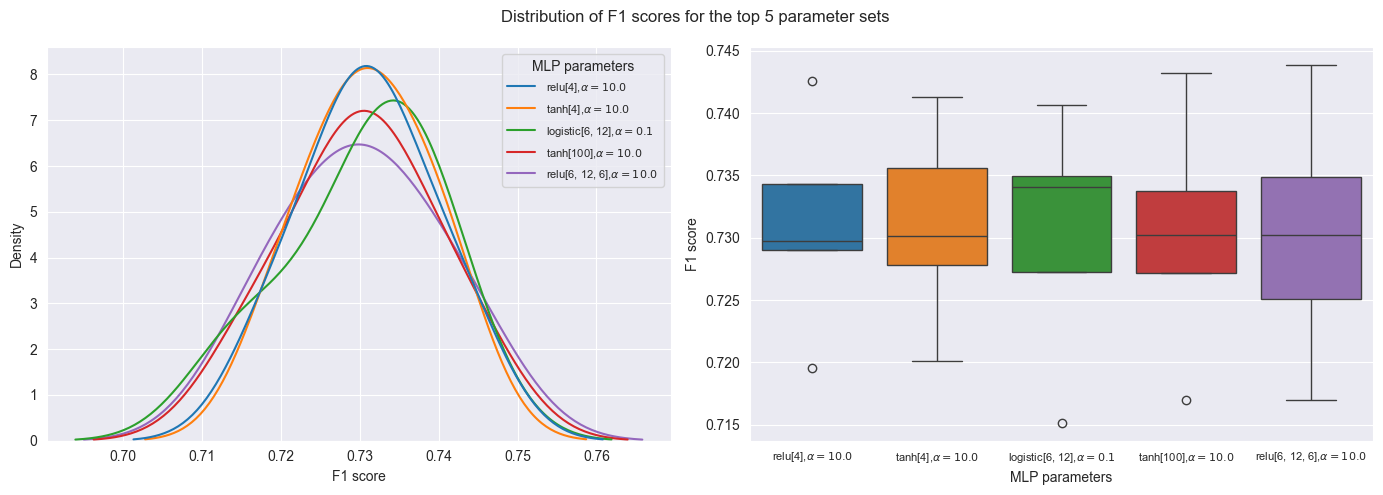

In [258]:
# We'll see this distribution in two ways: 1) as a KDE plot, good for having an
# idea of the mean and standard deviation; and, 2) as a boxplot, to focus on the
# median and quartiles
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Let's start with the KDE plot
sns.kdeplot(data=df_cv5l, x="f1_score", hue="params", ax=ax[0])
ax[0].set_xlabel("F1 score")
ax[0].get_legend().set_title("MLP parameters")
for leg_text in ax[0].get_legend().get_texts():
    leg_text.set_fontsize(8)

# And now for the boxplot
sns.boxplot(data=df_cv5l, x="params", y="f1_score", hue="params", ax=ax[1])
ax[1].set_xlabel("MLP parameters")
ax[1].set_ylabel("F1 score")
for x_label in ax[1].get_xticklabels():
    x_label.set_fontsize(8)

# Nice top title
fig.suptitle("Distribution of F1 scores for the top 5 parameter sets")

fig.tight_layout()

Again, we see small differences in the F1 score distribution for the top 5
parameter sets. While high regularization with $\alpha=10.0$ apparently
dominating, the other hyperparameters seem to be a bit all over the place. Let's
create three heatmaps, one per activation function, to better understand how
the F1 score varies between these hyperparameters.

In [259]:
# Let's create a column with a string version of the hidden layers list
df_cv_results["hidden_layers"] = df_cv_results["param_mlp__hidden_layer_sizes"].astype(str)

In [260]:
# Small helper function which, given a string-converted lists of numbers,
# returns the product of all those numbers
# We use it as a sort key for the "hidden_layers" column in the code below
# (i.e., dataframes will be sorted by total number of weights in the hidden
# layers)
def nweights_sort(list_of_ints_as_str):
    # data_int is a string-converted list of ints

    # Convert a string back into a Python list
    list_of_ints = literal_eval(list_of_ints_as_str)

    # Return the sorting key, which is basically the product on the list
    # contents, in other words, it's the number of weights in the hidden
    # layer(s)
    return np.prod(list_of_ints)

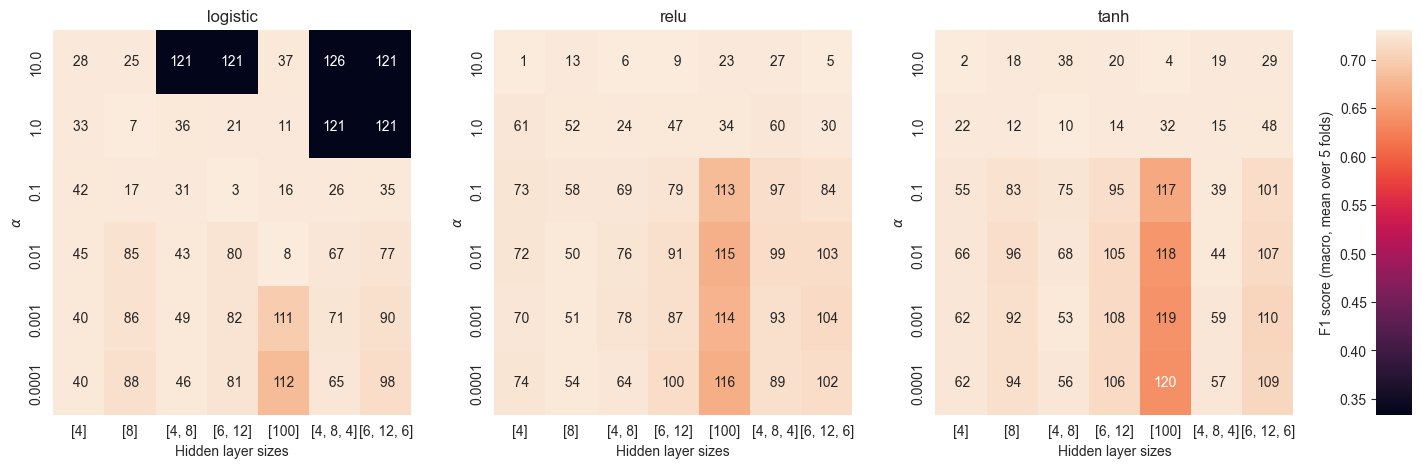

In [261]:
# Now we can start creating the heatmaps
# The "fourth" heatmap is just for us to put the legend
# The first three are for the different activation functions
fig, ax = plt.subplots(
    1, 4, figsize=(18, 5), gridspec_kw={"width_ratios": [1, 1, 1, 0.1]}
)
fig.subplots_adjust(wspace=0.3, right=0.88)

# We'll clamp the three heatmaps to the overall minimum and maximum mean F1
# scores, so that they are directly comparable
vmin = df_cv_results["mean_test_score"].min()
vmax = df_cv_results["mean_test_score"].max()

# Let's go through each activation function (sorted alphabetically)
for i, activation in enumerate(sorted(df_cv_results["param_mlp__activation"].unique())):

    # Filter dataframe by activation function
    df_cv_results_activ = df_cv_results[
        df_cv_results["param_mlp__activation"] == activation
    ]

    # Pivot dataframe so we have alpha in rows, hidden layers as columns,
    # and mean F1 score as the dataframe values
    df_pvted_f1sc = df_cv_results_activ.pivot(
        index="param_mlp__alpha", columns="hidden_layers", values="mean_test_score"
    )
    # Pivot a second support dataframe so we have alpha in rows, hidden layers
    # as columns, and the F1 score ranking as the dataframe values
    df_pvted_rank = df_cv_results_activ.pivot(
        index="param_mlp__alpha", columns="hidden_layers", values="rank_test_score"
    )

    # Let's sort the columns by number of weights in the hidden layer using our
    # helper function above
    # This makes the heatmaps easier to interpret, hopefully
    df_pvted_f1sc = df_pvted_f1sc[sorted(df_pvted_f1sc.columns, key=nweights_sort)]
    df_pvted_rank = df_pvted_rank[sorted(df_pvted_rank.columns, key=nweights_sort)]

    # Now we can plot the heatmap
    # The .iloc trick is just to reverse the data frame rows, so that alpha
    # appears from lower to higher in the y axis
    sns.heatmap(
        df_pvted_f1sc.iloc[::-1],
        annot=df_pvted_rank.iloc[::-1],
        fmt="3d",
        ax=ax[i],
        vmin=vmin,
        vmax=vmax,
        cbar=(i == 2),
        cbar_ax=ax[3],
        cbar_kws={"label": "F1 score (macro, mean over 5 folds)", "location": "left"},
    )  # , vmin=0.65, vmax=0.75)
    ax[i].set_xlabel("Hidden layer sizes")
    ax[i].set_ylabel("$\\alpha$")
    ax[i].set_title(activation)

Now a few interesting things can be inferred from these results:

- First, the lowest results are concentrated in the logistic activation with
  strong regularization and the number of layers is 2 or higher. This occurs
  because neural networks with logistic activations are very prone to saturation
  and vanishing gradients, requiring large weights to overcome it. In turn,
  strong regularization forces the weights to become even smaller, pushing the
  activations further into their flat, non-informative regions. When two or more
  hidden layers are combined with a high $\alpha$, the model underfits heavily.
- Second, with low regularization, logistic benefits from its inherently
  bounded, self-regularizing activations, giving it stable behavior and better
  generalization. ReLU and tanh lack this built-in constraint, so without
  regularization they are more prone to unstable weights, saturation (tanh), or
  overfitting (ReLU), which lowers their performance in that region of the
  heatmaps.
- Third, a hidden layer of 100 units performs badly with low regularization
  for all types of activation, while at the same time being able to almost
  always obtain good to excellent results with mid to high regularization. This
  happens because, with 100 units, it's much more expressive than the smaller
  architectures, so with low regularization it can very easily overfit, become
  unstable, or grow very large weights. That leads to poor generalization and
  therefore low F1 scores. With mid to high regularization, however, the large
  layer size becomes an advantage: the model has plenty of capacity, but the
  regularization keeps the weights controlled, preventing overfitting and
  keeping activations in reasonable ranges. This combination of high capacity +
  controlled weights, lets the 100-unit architecture learn rich patterns without
  becoming unstable, which is why its performance improves dramatically once
  regularization is applied.

These results show how neural network hyperparameters interact in complex and
sometimes counterintuitive ways: an architecture that performs well under
moderate regularization may collapse without it, while an activation function
that succeeds with shallow (e.g. one hidden layer) networks may fail when depth
increases. Since model capacity, activation choice, and regularization strength
can amplify or counteract one another, finding good performance requires a fine
balance rather than relying on isolated intuition. This is why systematic
hyperparameter search (ideally coupled with cross-validation, like we did here)
is essential: it evaluates configurations across diverse conditions, avoids
overfitting to a single setup, and identifies combinations that generalize
reliably rather than accidentally performing well under a narrow set of
circumstances.

For this dataset, the MLP shows the same sort of bias-variance trade-off seen in
the SVM classifier from last week: too little regularization lets larger
networks overfit the small, noisy fluctuations in game stats, while too much
regularization collapses the model and prevents it from capturing the broad
team-level advantages that matter for predicting the winner. Activation
functions also interact with depth. In particular, sigmoid networks can
saturate and ReLUs can become unstable without constraints, so good performance
appears only in a narrow band of hidden sizes and $\alpha$ values. Due to this
sensitivity, the MLP never substantially improves on the SVM's best mean F1: the
dataset's patterns are relatively smooth and low-dimensional, so the SVM with a
well-chosen RBF kernel already captures the signal effectively, leaving little
room for a neural network to do better.


### F1 score evolution for the training and test sets over 200 epochs

Unfortunately, `MLPClassifier` does not allow us to specify a callback function
to calculate the F1 score after each epoch in a full run. Therefore, we have two
options for doing partial, one epoch runs, which are similar, but not exactly
the same:

1. Set `warm_start=True` to keep weights, `max_iter=1` to perform a full epoch
   on each `fit()`, and then `fit()` + `predict()` (on both train and test data)
   for the specified number of epochs.
   - Note that parts of the training state are "restarted" each call to `fit()`;
     in particular, Adam's learning rate adjustments might be reset.
2. Call `partial_fit()` + `predict()` (on both train and test data) for the
   specified number of epochs.
   - The MPL internal state is truly continued across calls, namely Adam's
     moving averages of gradients, so it behaves more like one long training run
     split into chunks.
   - However, this approach processes the samples in the order they're passed,
     without internal reshuffling. Therefore, we need to reshuffle the training
     data before each call to `partial_fit()`.

We'll go with option 2, since it more faithfully reproduces a full run. In any
case, the source code for option 1 can be found at the end of this notebook for
completeness.

In [262]:
# Helper function to plot the F1 score and the loss curve over the specified
# number of epochs
def plot_f1_and_loss(f1_train, f1_test, loss_curve, n_epochs, sup_title):

    # Create the figure itself
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the F1 score for both the train and test data
    ax[0].plot(range(1, n_epochs + 1), f1_train, label="Train F1 (macro)")
    ax[0].plot(range(1, n_epochs + 1), f1_test, label="Test F1 (macro)")

    # Decorate the F1 score plot properly
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("F1 score (macro)")
    ax[0].legend()
    ax[0].set_ylim([0.66, 0.745])
    ax[0].grid(True)

    # Plot the loss curve
    ax[1].plot(range(1, n_epochs + 1), loss_curve)

    # Decorate the loss plot properly
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].set_ylim([0.545, 0.95])

    # Set the overall title
    fig.suptitle(sup_title)

In [263]:
# Parameters for the two MLPClassifier approaches
params_mlp = {
    "random_state": 321,
    "batch_size": 200, # be explicit about the batch size
    "activation": "relu",
    "alpha": 10,
    "hidden_layer_sizes": (4,)
}

# Number of epochs to train
n_epochs = 200

In [264]:
# Let's do a new train/test split -- the previous training set contained more
# balanced games, which are harder to predict, while the test set had slightly
# easier examples, skewing (inverting) the train/test F1 scores below
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=98789767
)

# Previously we used a pipeline, but now we'll need the scaled data directly,
# especially due to our tests with Keras below, so let's have our training and
# test data scaled and available for our next tests
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

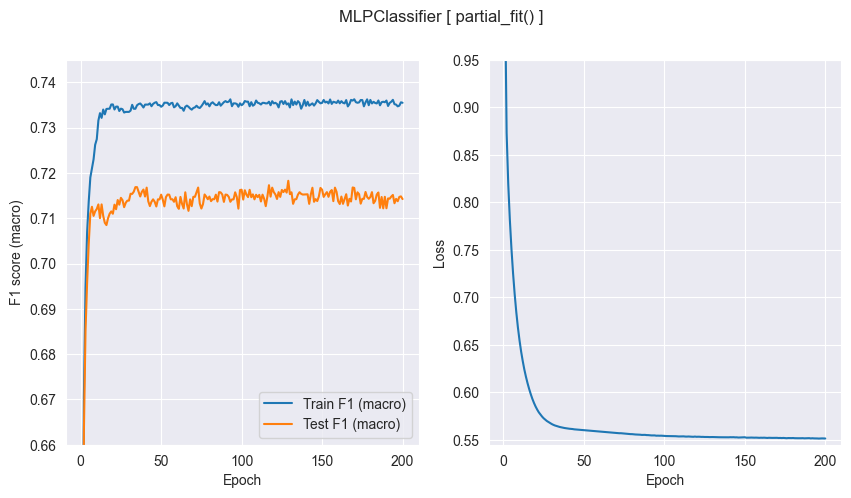

In [265]:
# Create a new MLPClassifier with the parameters specified above
mlp = MLPClassifier(**params_mlp)

# Get the unique labels (we need them for partial_fit())
classes = np.unique(y_train)

# Our train and test F1 scores
f1_train, f1_test = [], []

# Create an array of reproducible but really seeds so we can shuffle the
# training data before each partial fit
rng = np.random.Generator(np.random.MT19937(15691434))
seeds = rng.integers(0, 5000000, n_epochs)

# Iterate over epochs
for epoch in range(n_epochs):

    # Shuffle the training data using the seed for the current epoch
    X_train_scalshuf, y_train_shuf = shuffle(X_train_scaled, y_train, random_state=seeds[epoch])

    # Perform a partial fit of one epoch over the training data
    mlp.partial_fit(X_train_scalshuf, y_train_shuf, classes=classes)

    # Make predictions on train and test data
    y_pred_tr = mlp.predict(X_train_scalshuf)
    y_pred_te = mlp.predict(X_test_scaled)

    # Obtain the respective F1 scores
    f1_train.append(f1_score(y_train_shuf, y_pred_tr, average="macro"))
    f1_test.append(f1_score(y_test, y_pred_te, average="macro"))

# Plot results
plot_f1_and_loss(f1_train, f1_test, mlp.loss_curve_, n_epochs, "MLPClassifier [ partial_fit() ]")

The model seems to stabilize after 50 epochs, although the loss continues to
decrease slowly after that.

### Bonus: Implement an equivalent model in Keras with the best hyperparameters from the previous step

For some reason, Keras own F1 score function doesn't quite work as expected.
Therefore, before we start with Keras, let's create a F1 score callback
function, so we get correct results (within the context of a class, so we can
also keep those results).

In [266]:
# Compute exact macro-F1 on the full training and validation sets after each
# epoch, using sklearn.metrics.f1_score.
#
# This class extends Keras Callback class. Note that, contrary to Keras,
# scikit-learn's MLPClassifier doesn't support callbacks like this, that is why
# we used partial_fit().
class F1History(keras.callbacks.Callback):

    # The class constructor
    def __init__(self, X_train, y_train, X_val=None, y_val=None, threshold=0.5):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_val   = X_val
        self.y_val   = y_val
        self.th      = threshold
        self.f1_train = []
        self.f1_val   = []

    # Callback to be invoked after each epoch
    def on_epoch_end(self, epoch, logs=None):

        # Obtain the F1 score on the training data
        y_pred_train = (self.model.predict(self.X_train, verbose=0) >= self.th).astype(int)
        f1_tr = f1_score(self.y_train, y_pred_train, average="macro")
        self.f1_train.append(f1_tr)

        # Obtain the F1 score on the test data
        if self.X_val is not None and self.y_val is not None:
            y_pred_val = (self.model.predict(self.X_val, verbose=0) >= self.th).astype(int)
            f1_va = f1_score(self.y_val, y_pred_val, average="macro")
            self.f1_val.append(f1_va)

Now we can build an equivalent Keras model using it's declarative approach.

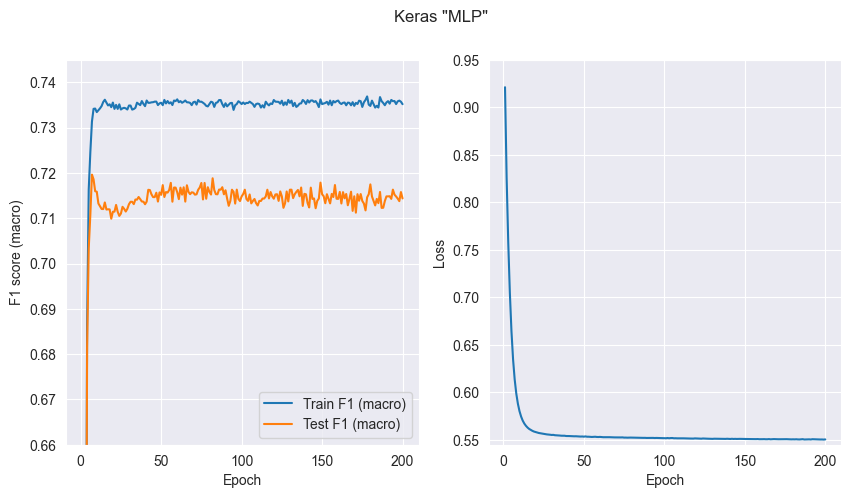

In [267]:
# Get number of features and samples, which will be useful below
num_features = X_train_scaled.shape[1]
n_samples = X_train_scaled.shape[0]

# L2 regularization factor, works differently from scikit-learn
# The value here is an approximation that provides similar results to
# MLPClassifier
l2_factor = 0.025

# For Keras, the labels need to be 1D arrays
y_train_bin = y_train.reshape(-1, 1)
y_test_bin = y_test.reshape(-1, 1)

# Initializer for the weights of the hidden layer, which is similar to what
# is used by MLPClassifier in the case of ReLU activation
hiddenlayer_init = initializers.GlorotUniform(seed=1234567)

# Initializer for the weights of the output layer, mimicking what MLPClassifier
# does for the sigmoid activation function
init_lim_sigmoid = np.sqrt(2 / (4 + 1)) # 4 inputs + 1 output in output layer
outputlayer_init = initializers.RandomUniform(
    minval=-init_lim_sigmoid, maxval=init_lim_sigmoid, seed=7654321
)

# Define the model
# In Keras this is done declaratively, i.e., we state exactly what each layer is
# and what it contains
# A Dense layer means a fully-connected feedforward layer, as it exists in MLPs
model = keras.Sequential(
    [
        # The input layer, which accepts the number of features in the LoL dataset
        layers.Input(shape=(num_features,)),
        # One single hidden layer, with four units, ReLU activation and weight
        # regularization
        layers.Dense(
            4,
            activation="relu",
            kernel_regularizer=regularizers.l2(l2_factor),
            kernel_initializer=hiddenlayer_init,
            bias_initializer=hiddenlayer_init,
        ),
        # The output layer, one output with sigmoid activation and weight
        # regularization
        layers.Dense(
            1,
            activation="sigmoid",
            kernel_regularizer=regularizers.l2(l2_factor),
            kernel_initializer=outputlayer_init,
            bias_initializer=outputlayer_init,
        ),
    ]
)

# After the model has been defined, we can now compile, specifying the
# optimizer and loss function
model.compile(
    # The optimizer we used in MLPClassifier
    # (the only different default is epsilon)
    optimizer=keras.optimizers.Adam(epsilon=1e-8),
    # The loss we used in MLPClassifier
    loss="binary_crossentropy",
)

# Instantiate our F1 class
f1_callback = F1History(
    X_train_scaled,
    y_train,
    X_val=X_test_scaled,
    y_val=y_test_bin,
    threshold=0.5,
)

# Let's train the model
history = model.fit(
    # Training data
    X_train_scaled,
    y_train_bin,
    # Validation data, used to calculate the F1 score on test data
    validation_data=(X_test_scaled, y_test_bin),
    # Number of epochs
    epochs=n_epochs,
    # Batch size, same as the one used in MLPClassifier
    batch_size=params_mlp["batch_size"],
    # No output while training
    verbose=0,
    # Register the function to calculate the F1 score as a callback
    callbacks=[f1_callback],
    # Shuffle, like we do in scikit-learn
    shuffle=True,
)

# Plot results
plot_f1_and_loss(
    f1_callback.f1_train,
    f1_callback.f1_val,
    history.history["loss"],
    n_epochs,
    'Keras "MLP"',
)

We obtain a very similar result compared to `MLPClassifier`. While it's clear
that the models are mostly equivalent, it's also clear that they're not exactly
the same. This is probably due to how L2 regularization is performed in both
frameworks, which is quite different and different to fully mimic in Keras.

This demonstrates that scikit-learn's `MLPClassifier` makes many choices for us,
and is not fully configurable. Keras, in turn, allows us to build neural
networks from the ground up, with our Keras "MLP" just being an example of how
powerful this framework is.

### Extra: MLPClassifier with warm start

This should yield generally similar results, but don't forget that Adam's
parameters are reset each time we call `fit()`, which means that the effective
learning rate is never updated.

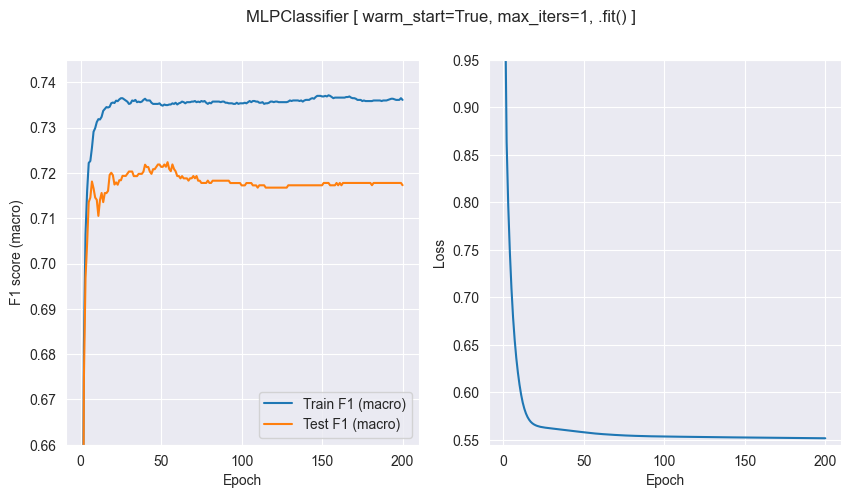

In [268]:
# Create a new MLPClassifier with warm start and max. iterations set to 1
mlp = MLPClassifier(max_iter=1, warm_start=True, **params_mlp)

# Our train and test F1 scores
f1_train = []
f1_test = []

# Iterate over epochs
for epoch in range(n_epochs):

    # Train for one epoch (because max_iter=1), ignore convergence warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        mlp.fit(X_train_scaled, y_train)

    # Make predictions on train and test data
    y_pred_train = mlp.predict(X_train_scaled)
    y_pred_test = mlp.predict(X_test_scaled)

    # Obtain the respective F1 scores
    f1_train.append(f1_score(y_train, y_pred_train, average="macro"))
    f1_test.append(f1_score(y_test, y_pred_test, average="macro"))

# Plot results
plot_f1_and_loss(
    f1_train,
    f1_test,
    mlp.loss_curve_,
    n_epochs,
    "MLPClassifier [ warm_start=True, max_iters=1, .fit() ]",
)

As can be observed, results are slightly different from those with
`partial_fit()`. In particular, the stable part of F1, after epoch 10, seems
smoother in this version. This is likely related with the fact that Adam's
parameters are being reset each iteration.